## 6.3 LSTM 구현
다음은 LSTM에서 수행하는 계산을 정리한 수식이다. 

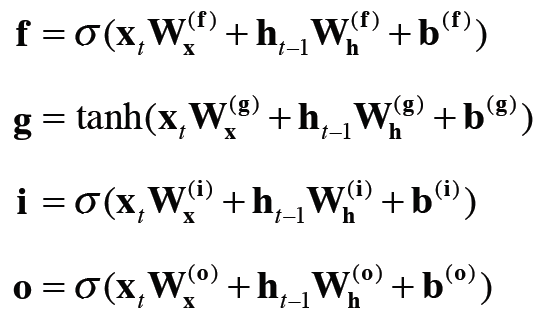

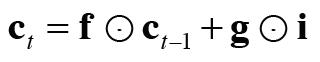

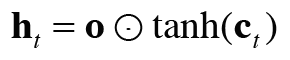

여기서 주목할 부분은 위쪽의 네 수식에 포함된 아핀 변환(affine transformation)이다. 

> 아핀 변환   
행렬 변환과 평행 이동(편향)을 결합한 형태의 식. $\mathbf x\mathbf W_{\mathbf x} + \mathbf h \mathbf W_{\mathbf h} + \mathbf b$

이 네 수식에서는 아핀 변환을 개별적으로 수행하지만 이를 하나의 식으로 정리할 수 있다.

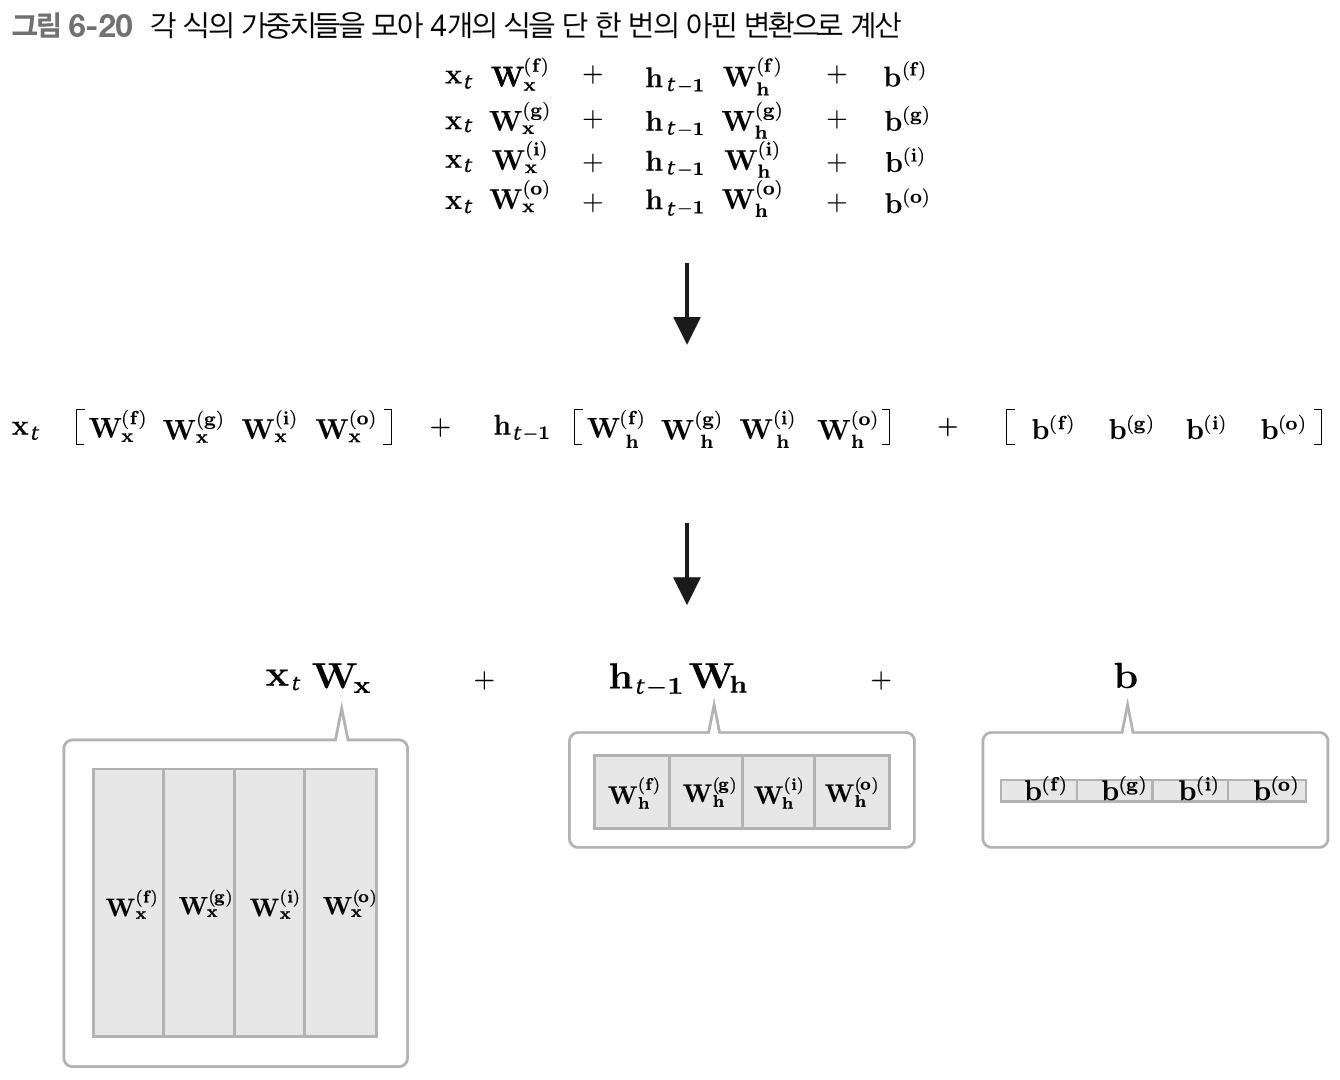

4 개의 가중치(또는 편향)를 하나로 모을 수 있고, 그렇게 하면 개별적으로 총 4번을 수행하던 아핀 변환을 1회의 계산으로 마칠 수 있다. 따라서 계산 속도가 빨라지며 소스 코드도 간결해진다.

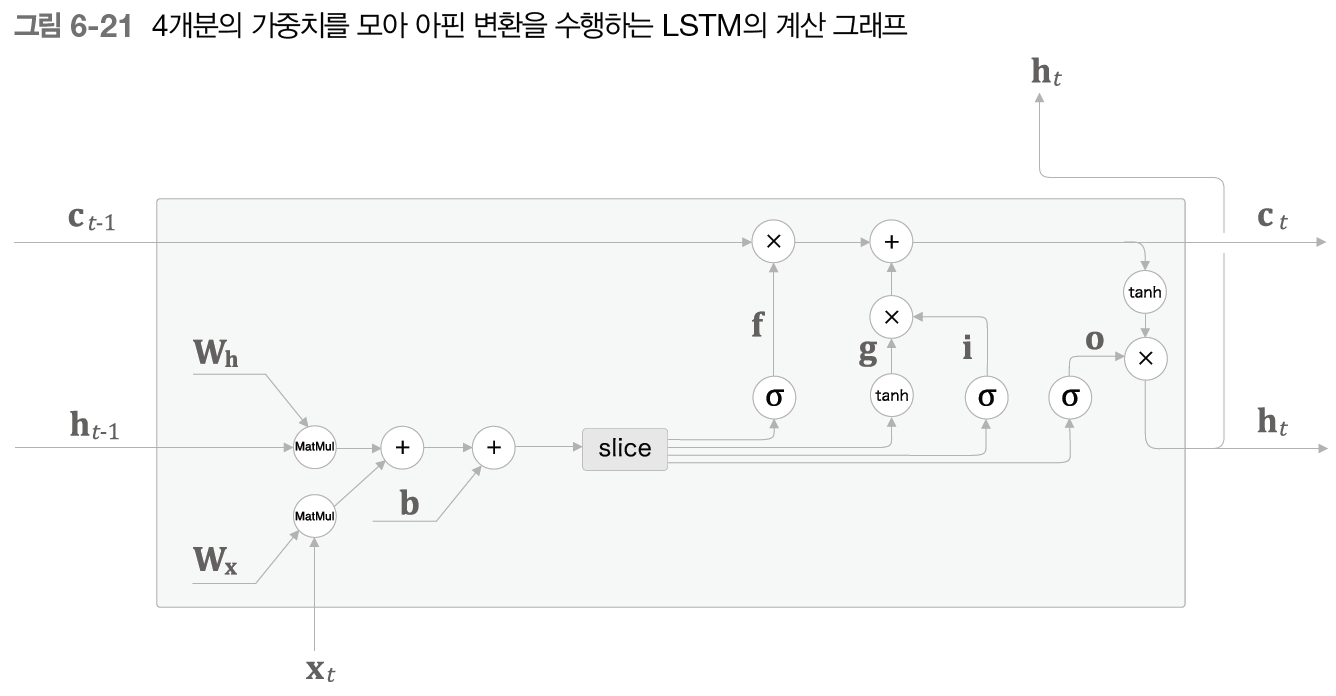

처음 4개분의 아핀 변환을 한 번에 수행하고 slice 노드를 통해 그 4개의 결과를 꺼낸다. slice 는 아핀 변환의 결과(행렬)를 균등하게 네 조각으로 나눠서 꺼내주는 노드이다. slice 노드 다음에는 활성화 함수(시그모이드 함수 또는 tanh 함수)를 거쳐 앞 절에서 설명한 계산을 수행한다. 



In [1]:
# LSTM 클래스 구현

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        # 기울기 초기화
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # 순전파 때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도의 인스턴스 변수
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # 아핀 변환
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(i)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        
        return h_next, c_next
    

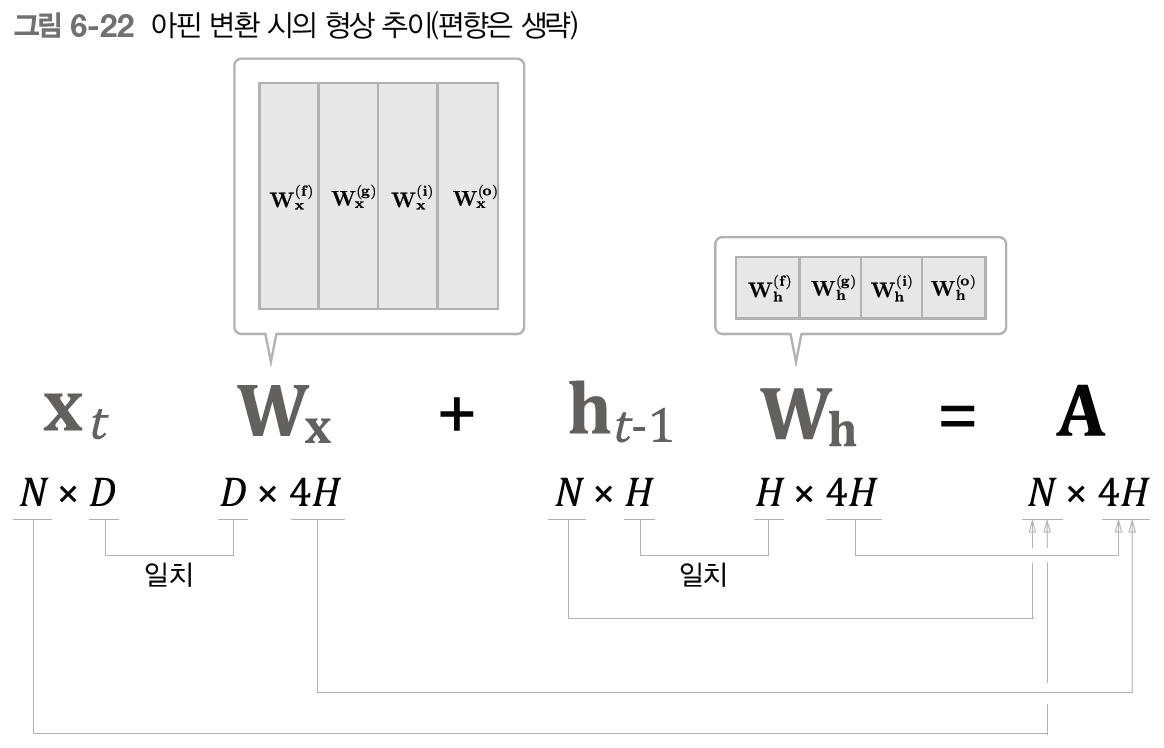

N: 미니배치의 수, D: 입력 데이터의 차원의 수, H: 기억 셀과 은닉 상태의 차원 수    
A: 아핀 변환의 결과, 4개 분의 아핀 변환 결과가 저장

A에서 데이터를 꺼낼 때는 슬라이스해서 꺼내고, 꺼낸 데이터를 다음 연산 노드에 분배한다. 

> LSTM 계층은 4 개분의 가중치를 하나로 모아 보관하므로 매개변수를 3개만 관리하면 된다. RNN와 매개변수의 수가 같지만 형상은 다르다.

LSTM의 역전파는 순전파의 계산 그레프를 역방향으로 전파해 구할 수 있다. 순전파에서 slice 노드는 행렬을 4조각으로 나눠 분배했으므로 역전파에서는 4개의 기울기를 결합하면 된다.

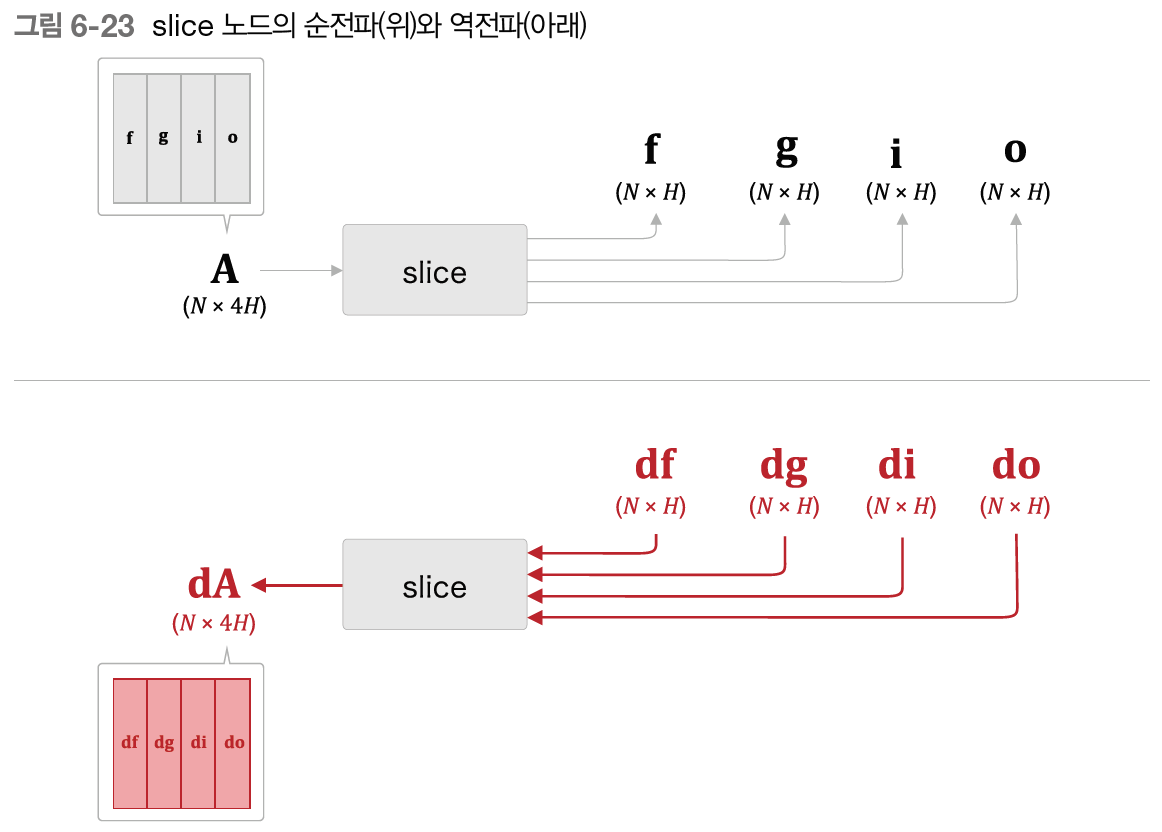

4개의 기울기 $\mathbf {df}, \mathbf {dg}, \mathbf {di}, \mathbf {do}$를 연결해 $\mathbf {dA}$를 만든다. 넘파이로 수행하려면 ```np.hstack()``` 메서드를 사용한다. ```np.hstack()``` 메서드는 인수로 주어진 배열들을 가로로 연결한다. (세로로 연결하면 ```np.vstack()```)

In [4]:
import numpy as np

dA = np.vstack((df, dg, di, do))

In [5]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        # affine transformation
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        # gate
        f = sigmoid(f)
        g = np.tanh(g)  # new memory cell
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
  
        # sigmoid 미분
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)  #  tanh 미분
        
        # 4개의 기울기 연결
        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


### 6.3.1 Time LSTM 구현
Time LSTM은 T개분의 시계열 데이터를 한 번에 처리하는 계층이다. 

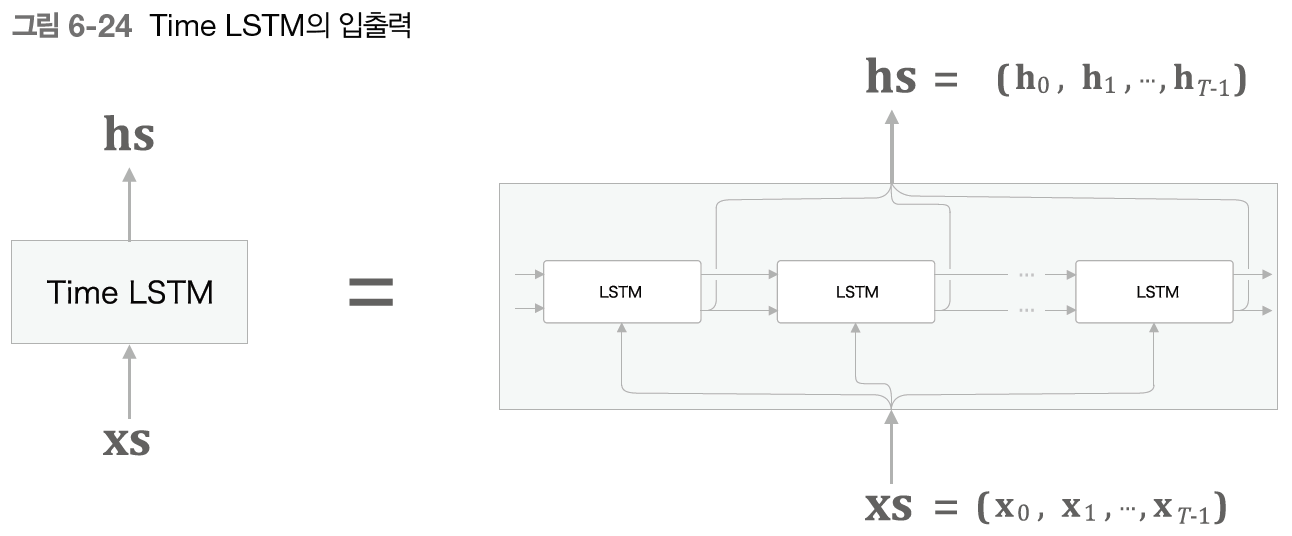

RNN과 같이 Truncated BPTT(순전파의 흐름은 그대로 유지, 역전파의 연결을 적당한 길이로 끊음)를 수행한다. 따라서 아래 그림과 같이 은닉 상태와 기억 셀을 인스턴스 변수로 유지하여 다음 번에 forward()가 불렸을 때, 이전 시각의 은닉 상태(와 기억 셀)에서부터 시작할 수 있다. 

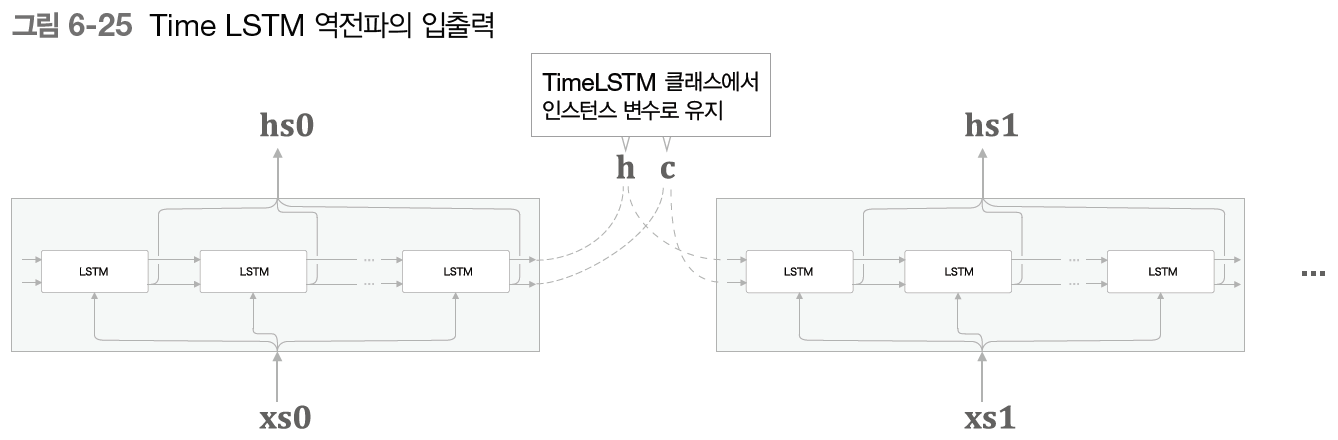


In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful  # 상태를 유지할지 지정

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N: 미니배치 크기, T: 시계열의 분량, D: 입력 벡터의 차원 수 
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')  # 출력값을 담을 그릇 준비
        
        # 은닉 상태, 기억 셀 초기화, 처음 호출시 또는 stateful=False
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        # LSTM 계층 셍성해 인스턴스 변수 layer에 추가
        for t in range(T):
            layer = LSTM(*self.params)   # *self.params는 리스트의 원소들을 추출해 메서드의 인수로 전달
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c) # 은닉상태, 기억셀 계산
            hs[:, t, :] = self.h  # 은닉상태를 hs에 인덱스(시각)의 값으로 저장

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')  # 기울기 담을 그릇
        dh, dc = 0, 0

        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 순전파에서 출력이 2개로 분기되므로 역전파에서는 기울기를 합산한다.
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)  
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

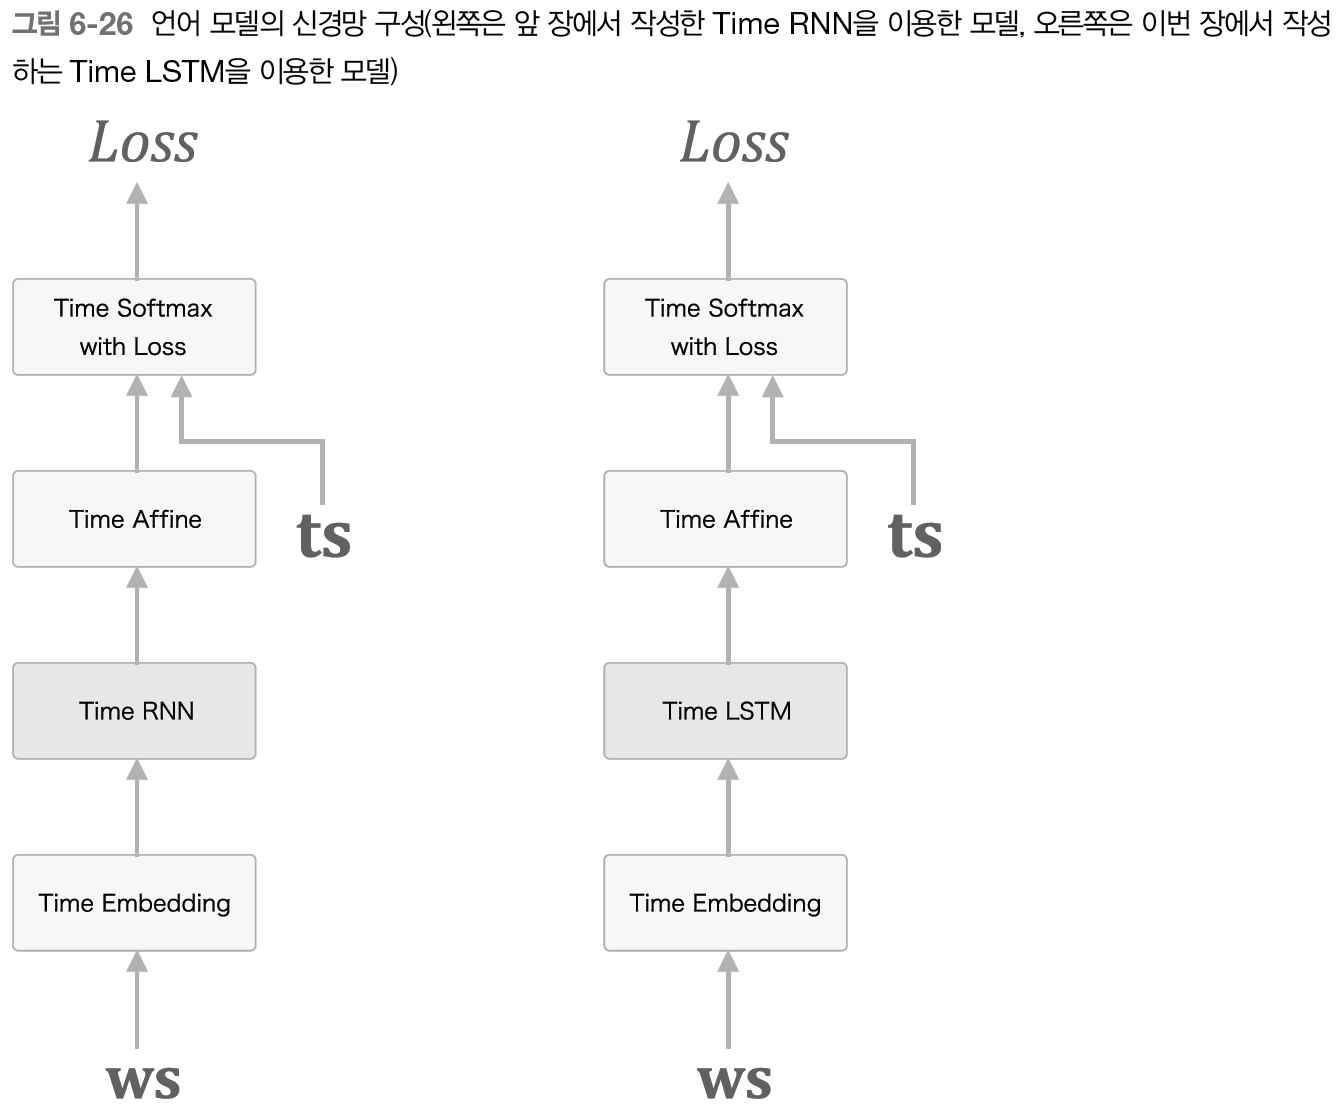

In [11]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel
import pickle


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)   # 데이터 입력
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)  # 데이터 로드

In [ ]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                m
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                # 기울기 클리핑
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                # 매개변수 갱신
                optimizer.updateodel.backward()(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()

In [ ]:
def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.44
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 2992.45
| 에폭 1 |  반복 41 / 1327 | 시간 4[s] | 퍼플렉서티 1184.20
| 에폭 1 |  반복 61 / 1327 | 시간 5[s] | 퍼플렉서티 1005.11
| 에폭 1 |  반복 81 / 1327 | 시간 7[s] | 퍼플렉서티 792.75
| 에폭 1 |  반복 101 / 1327 | 시간 9[s] | 퍼플렉서티 653.58
| 에폭 1 |  반복 121 / 1327 | 시간 11[s] | 퍼플렉서티 638.60
| 에폭 1 |  반복 141 / 1327 | 시간 13[s] | 퍼플렉서티 598.86
| 에폭 1 |  반복 161 / 1327 | 시간 15[s] | 퍼플렉서티 586.68
| 에폭 1 |  반복 181 / 1327 | 시간 17[s] | 퍼플렉서티 570.78
| 에폭 1 |  반복 201 / 1327 | 시간 19[s] | 퍼플렉서티 511.13
| 에폭 1 |  반복 221 / 1327 | 시간 21[s] | 퍼플렉서티 497.47
| 에폭 1 |  반복 241 / 1327 | 시간 23[s] | 퍼플렉서티 443.55
| 에폭 1 |  반복 261 / 1327 | 시간 25[s] | 퍼플렉서티 468.72
| 에폭 1 |  반복 281 / 1327 | 시간 27[s] | 퍼플렉서티 461.93
| 에폭 1 |  반복 301 / 1327 | 시간 29[s] | 퍼플렉서티 393.93
| 에폭 1 |  반복 321 / 1327 | 시간 31[s] | 퍼플렉서티 350.45
| 에폭 1 |  반복 341 / 1327 | 시간 33[s] | 퍼플렉서티 400.10
| 에폭 1 |  반복 361 / 1327 | 시간 35[s] | 퍼플렉서티 403.48
| 에폭 1 |  반복 381 / 1327 | 시간 37[s] | 퍼플렉서티 337.12
| 에폭 1 |

| 에폭 3 |  반복 561 / 1327 | 시간 315[s] | 퍼플렉서티 119.39
| 에폭 3 |  반복 581 / 1327 | 시간 317[s] | 퍼플렉서티 104.37
| 에폭 3 |  반복 601 / 1327 | 시간 319[s] | 퍼플렉서티 147.42
| 에폭 3 |  반복 621 / 1327 | 시간 321[s] | 퍼플렉서티 142.96
| 에폭 3 |  반복 641 / 1327 | 시간 323[s] | 퍼플렉서티 128.48
| 에폭 3 |  반복 661 / 1327 | 시간 325[s] | 퍼플렉서티 119.37
| 에폭 3 |  반복 681 / 1327 | 시간 327[s] | 퍼플렉서티 100.32
| 에폭 3 |  반복 701 / 1327 | 시간 329[s] | 퍼플렉서티 118.50
| 에폭 3 |  반복 721 / 1327 | 시간 331[s] | 퍼플렉서티 125.76
| 에폭 3 |  반복 741 / 1327 | 시간 333[s] | 퍼플렉서티 106.89
| 에폭 3 |  반복 761 / 1327 | 시간 335[s] | 퍼플렉서티 102.84
| 에폭 3 |  반복 781 / 1327 | 시간 337[s] | 퍼플렉서티 103.30
| 에폭 3 |  반복 801 / 1327 | 시간 339[s] | 퍼플렉서티 114.86
| 에폭 3 |  반복 821 / 1327 | 시간 341[s] | 퍼플렉서티 116.40
| 에폭 3 |  반복 841 / 1327 | 시간 342[s] | 퍼플렉서티 114.64
| 에폭 3 |  반복 861 / 1327 | 시간 344[s] | 퍼플렉서티 119.67
| 에폭 3 |  반복 881 / 1327 | 시간 346[s] | 퍼플렉서티 105.49
| 에폭 3 |  반복 901 / 1327 | 시간 348[s] | 퍼플렉서티 131.25
| 에폭 3 |  반복 921 / 1327 | 시간 350[s] | 퍼플렉서티 119.41
| 에폭 3 |  반복 941 / 1327 | 시간 35

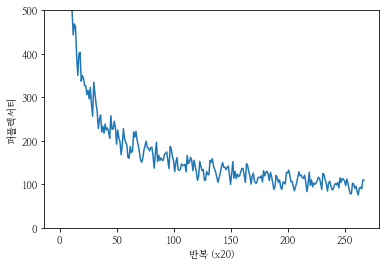

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.3183609697439


In [12]:
# PTB 데이터셋 전부를 학습

# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
# from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
# RnnlmTrainer 클래스를 사용해 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)  # 20번째 반복마다 퍼플렉서티 평가
trainer.plot(ylim=(0, 500))  # 결과를 그래프로 그림

# 테스트 데이터로 평가(퍼플렉서티)
model.reset_state()  # 모델 상태(은닉상태와 기억셀)을 재설정해서 평가
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


퍼플렉서티는 다음에 나올 수 있는 후보 단어 수가 9999개 정도로 줄었다는 뜻이다. 데이터셋의 어휘수가 10,000개이므로 거의 아무 것도 학습하지 않은 상태이다. 

이 실험에서는 총 4 에폭(반복으로 환산하면 1327\*4회) 학습이 수행되었다. 이 모델은 다은에 나올 단어의 후보를 총 10,000개 중에서 135개 정도로 줄일 때까지 개선되었다. 그러나 이 결과는 좋은 결과는 아니다. 2017년 기준 최첨단 연구에서는 PTB 데이터셋의 퍼플렉서티가 60을 밑돈다. 

## 6.5 RNNLM 추가 개선
### 6.5.1 LSTM 계층 다층화
RNNLM으로 정확한 모델을 만들려면 많은 경우 LSTM 계층을 깊게(여러 개) 쌓아 효과를 볼 수 있다.

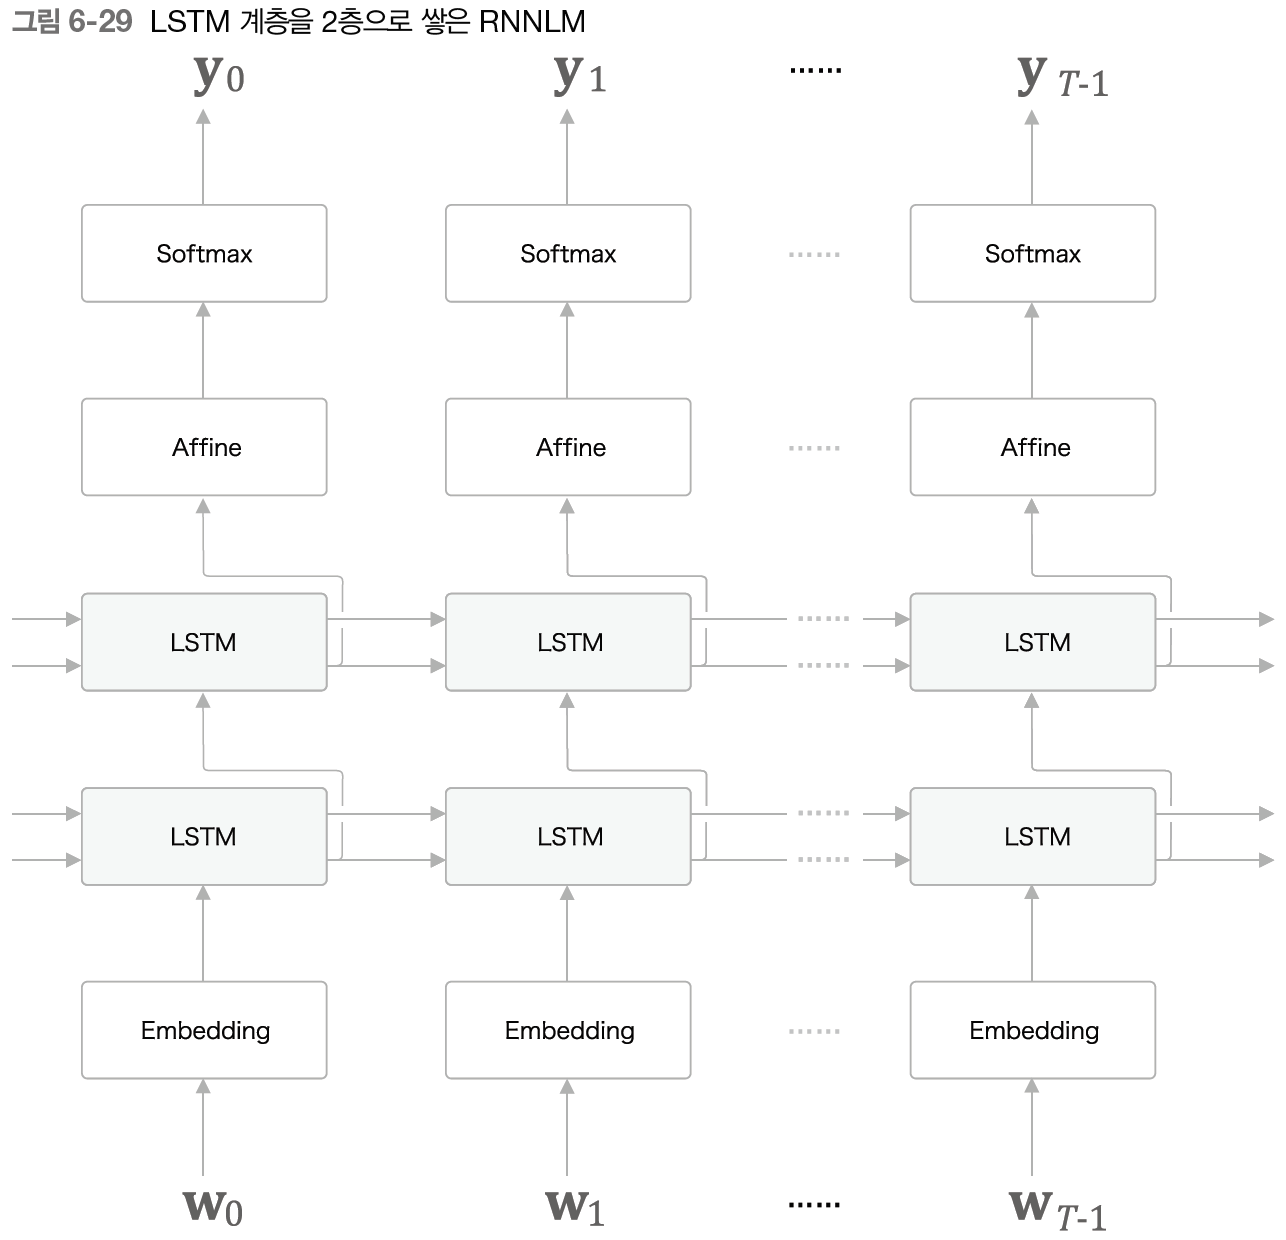

위 그림처럼 LSTM 계층을 2개 쌓으면 첫 번째 LSTM 계층의 은닉 상태가 두 번째 LSTM 계층에 입력된다. 이런 방식으로 LSTM 계층을 몇 층이라도 쌓을 수 있고, 그 결과 더 복잡한 패턴을 학습할 수 있다. 

쌓는 층 수는 하이퍼파라미터이므로 처리할 문제의 복잡도나 준비된 학습 데이터의 양에 따라 적절하게 결정해야 한다. 참고로 PTB 데이터셋의 언어 모델에서는 LSTM의 층 수는 2-4일 때 좋은 결과를 얻는 것 같다. 

> 구글 번역에 사용되는 GNMT 모델은 LSTM을 8층 쌓은 신경망이다. 처리할 문제가 복잡하고 학습 데이터를 대량으로 준비할 수 있다면 LSTM 계층을 깊게 쌓는 것이 정확도 향상을 이끌 수 있다. 

### 6.5.2 드롭아웃에 의한 과적합 억제
LSTM 계층을 다층화하면 시계열 데이터의 복잡한 의존 관계를 학습할 수 있다. 즉 층을 깊게 쌓아 표현력이 풍부한 모델을 만들 수 있다. 그러나 이런 모델은 종종 과적합 overfitting을 일이킨다. RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킨다. 

과적합을 억제하기 위한 '훈련 데이터의 양 늘리기'와 '모델의 복잡도 줄이기'라는 전통적인 방법과 모델의 복잡도에 페널티를 주는 __정규화(normalization)__ 이 효과적이다. 

드롭아웃처럼 훈련 시 계층 내 뉴련 몇 개(50% 등)를 무작위로 무시하고 학습하는 방법도 일종의 정규화이다. 

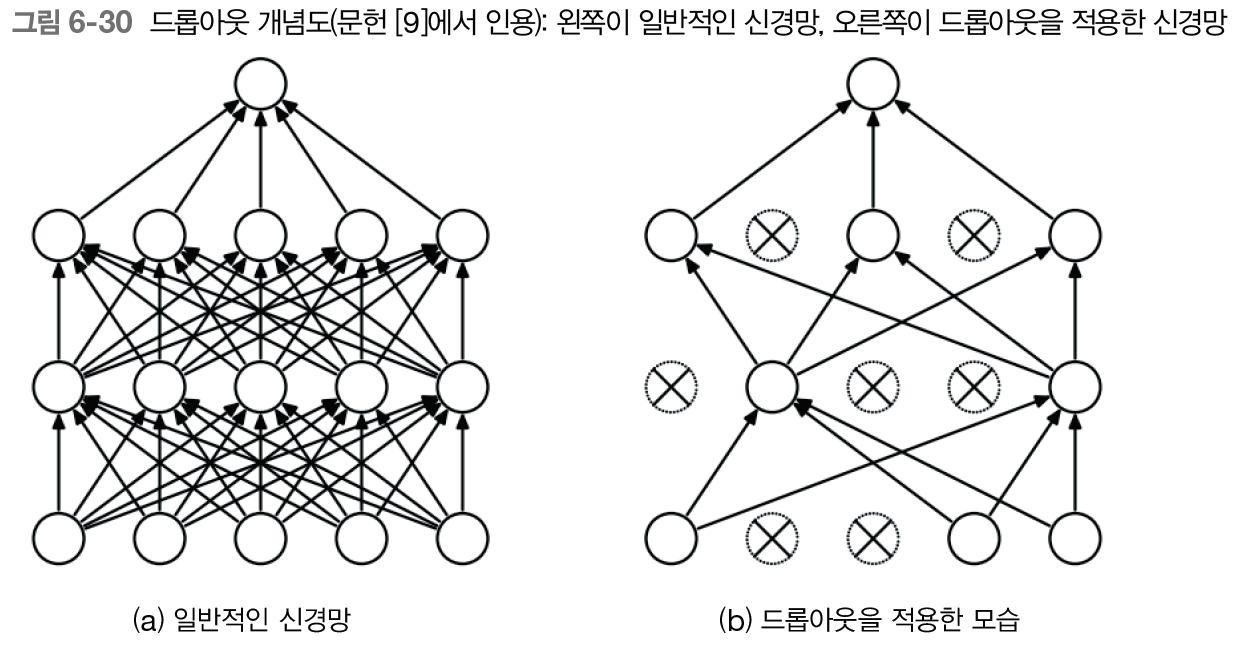

드롭아웃은 무작위로 뉴런을 선택해 선택한 뉴런을 무시한다. 무시한다는 말은 그 앞 계층으로부터 신호 전달을 막는다는 뜻이고, 이 무작위한 무시가 제약이 되어 신경망의 일반화 성능을 개선한다. 피드포워드 신경망에서는 드롭아웃 계층을 활성화 함수 뒤에 삽입하여 과적합 억제에 기여할 수 있었다. 

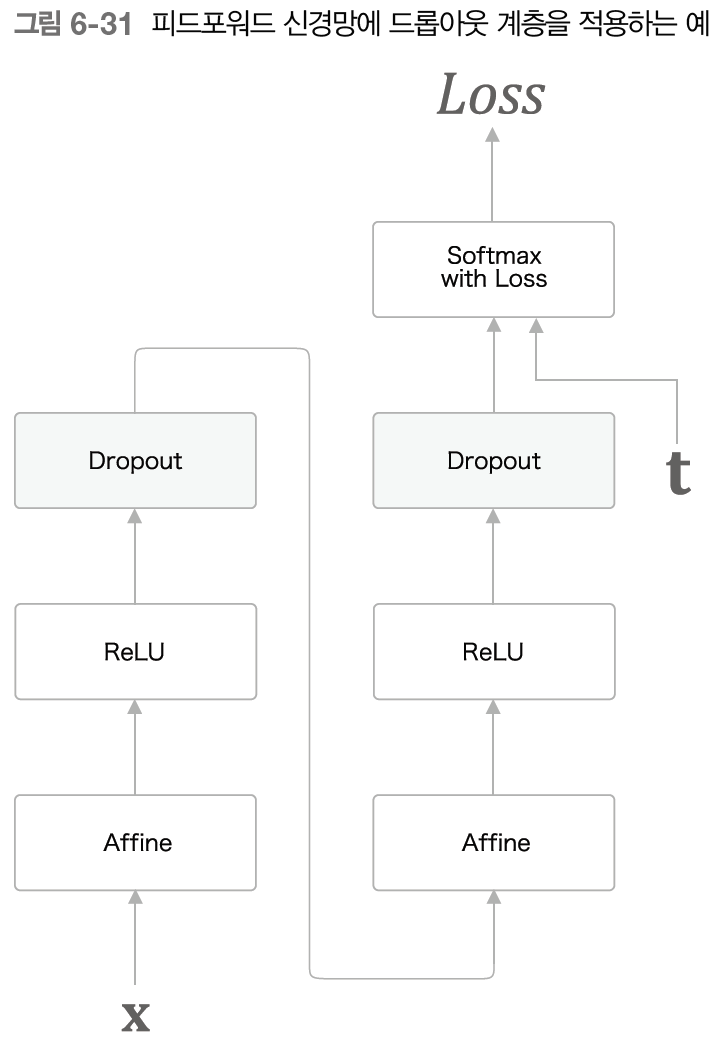

RNN을 사용한 모델에서는 드롭아웃을 시계열 방향으로 넣으면 학습시 시간이 흐름에 따라 정보가 사라질 수 있다. 즉 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다. 

따라서 드롭아웃 계층을 깊이 방향(상하 방향)으로 삽입하는 방법이 좋다. 

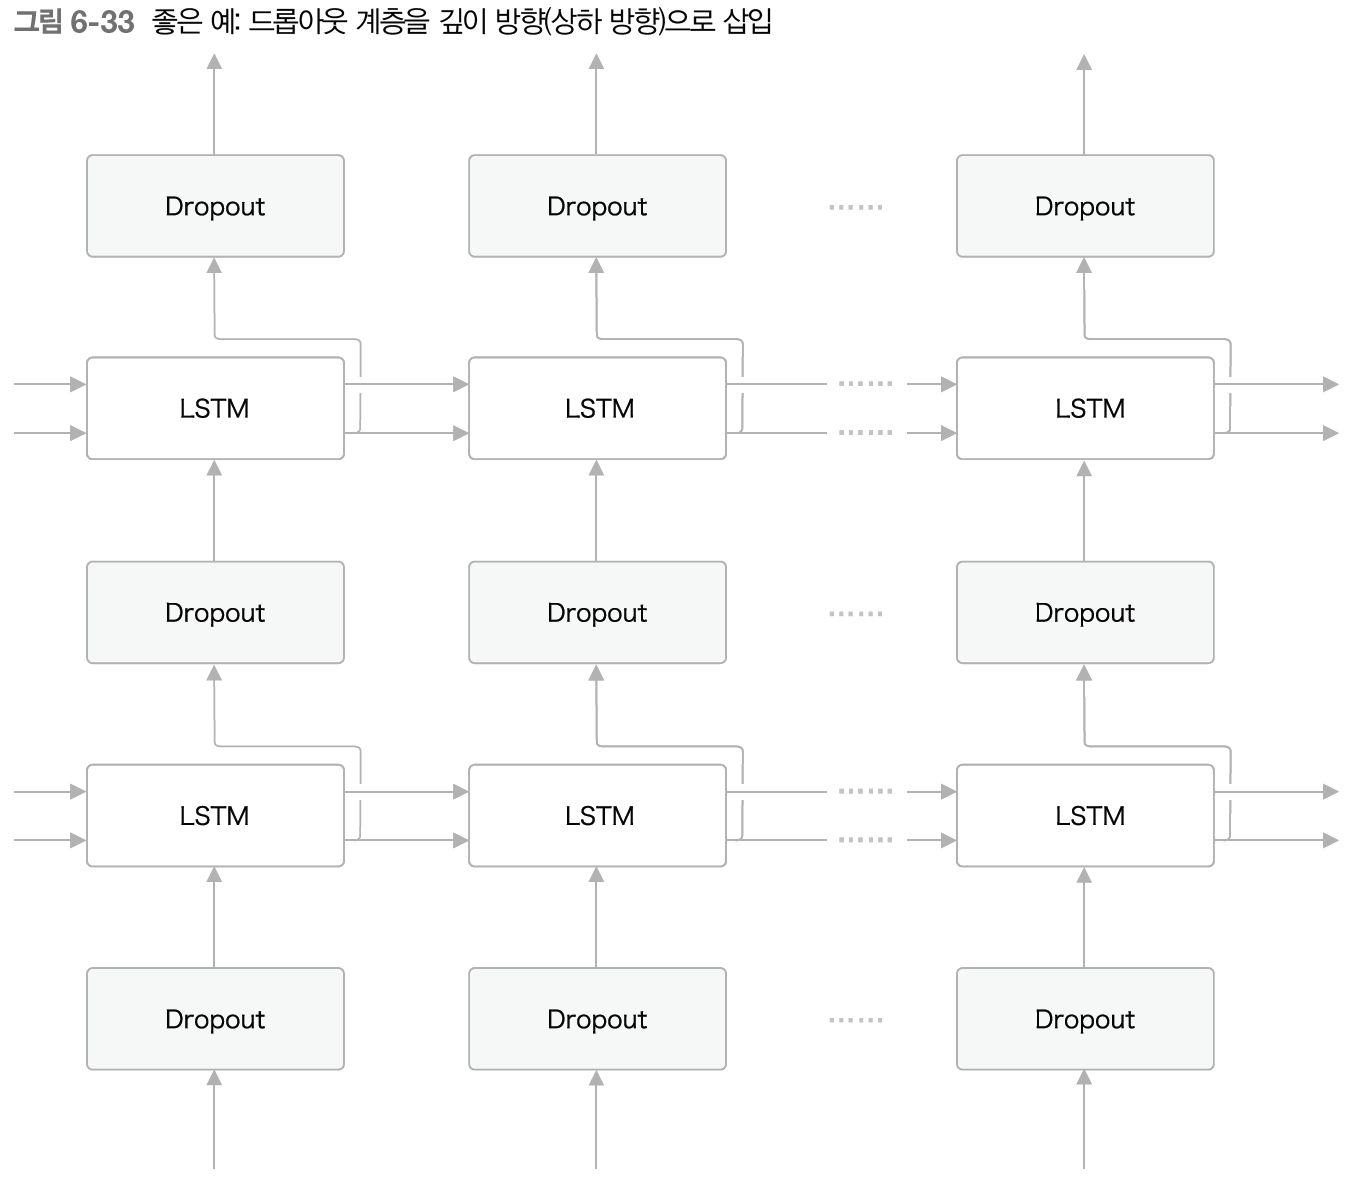

이렇게 구성하면 시간 방향(좌우 방향)으로 아무리 진행해도 정볼르 잃지 않는다. 드롭아웃이 시간축과는 독립적으로 깊이 방향(상하 방향)에만 영향을 준다. 

최근 연구에서는 RNN의 시간 방향 정규화를 목표로 하는 방법이 다양하게 제안되고 있는데, 그 중 하나가 변형 드롭아웃(Variational Dropout)이다. 변형 드롭아웃은 시간 방향으로 드롭아웃을 적용하는 데 성공했다. 변형 드롭아웃은 깊이 방향과 함께 시간 방향에도 이용할 수 있어서 언어 모델의 정확도를 보다 더 향상시킬 수 있다. 같은 계층에 속한 드롭아웃들은 같은 마스크를 공유한다. 여기서의 '마스크'는 데이터의 '통과/차단'을 결정하는 이진(binary) 형태의 무작위 패턴이다. 

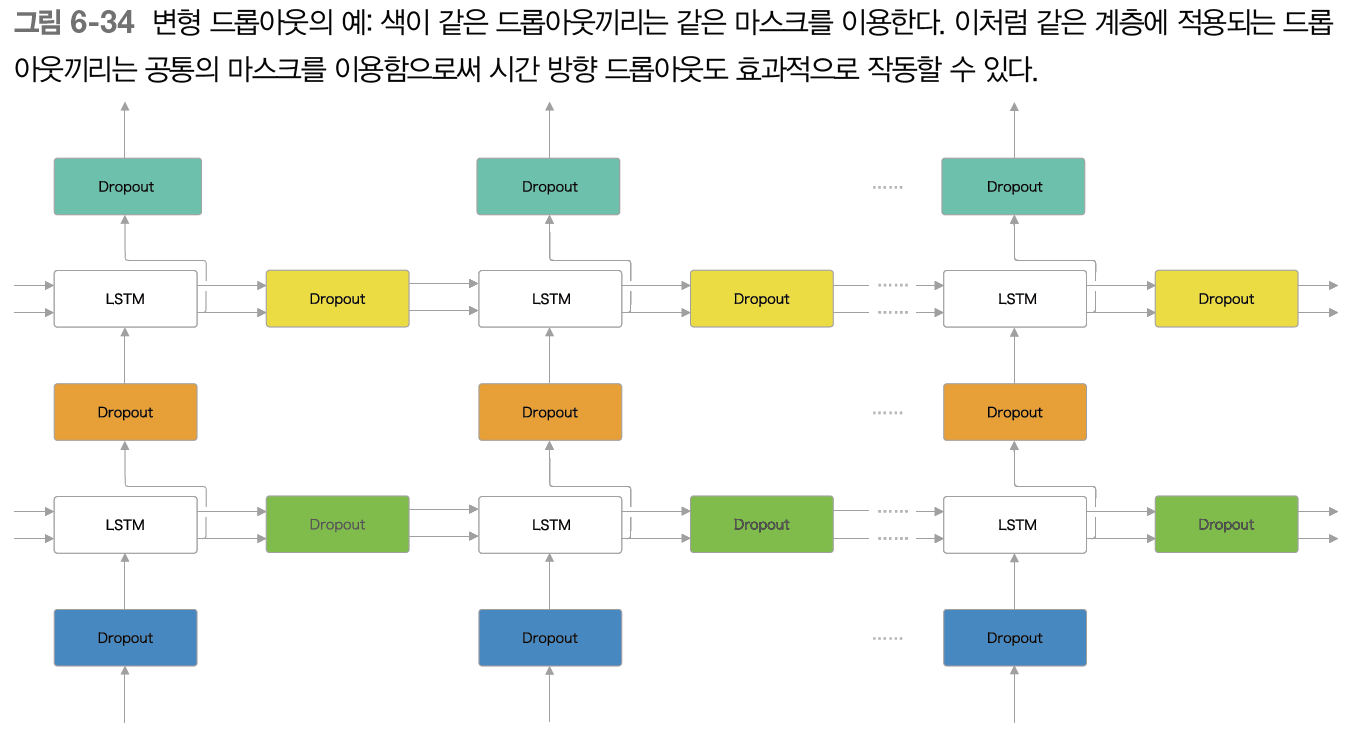

같은 계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 '고정'된다. 그 결과 정보를 잃게 되는 방법도 '고정'되므로 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있다. 변형 드롭아웃은 일반 드롭아웃보다 결과가 좋다고 한다. 그러나 여기서는 일반적인 드롭아웃을 사용한다. 

### 6.5.3 가중치 공유
언어 모델을 개선하는 아주 간단한 방법 중 하나는 가중치 공유(weight tying)이 있다. 

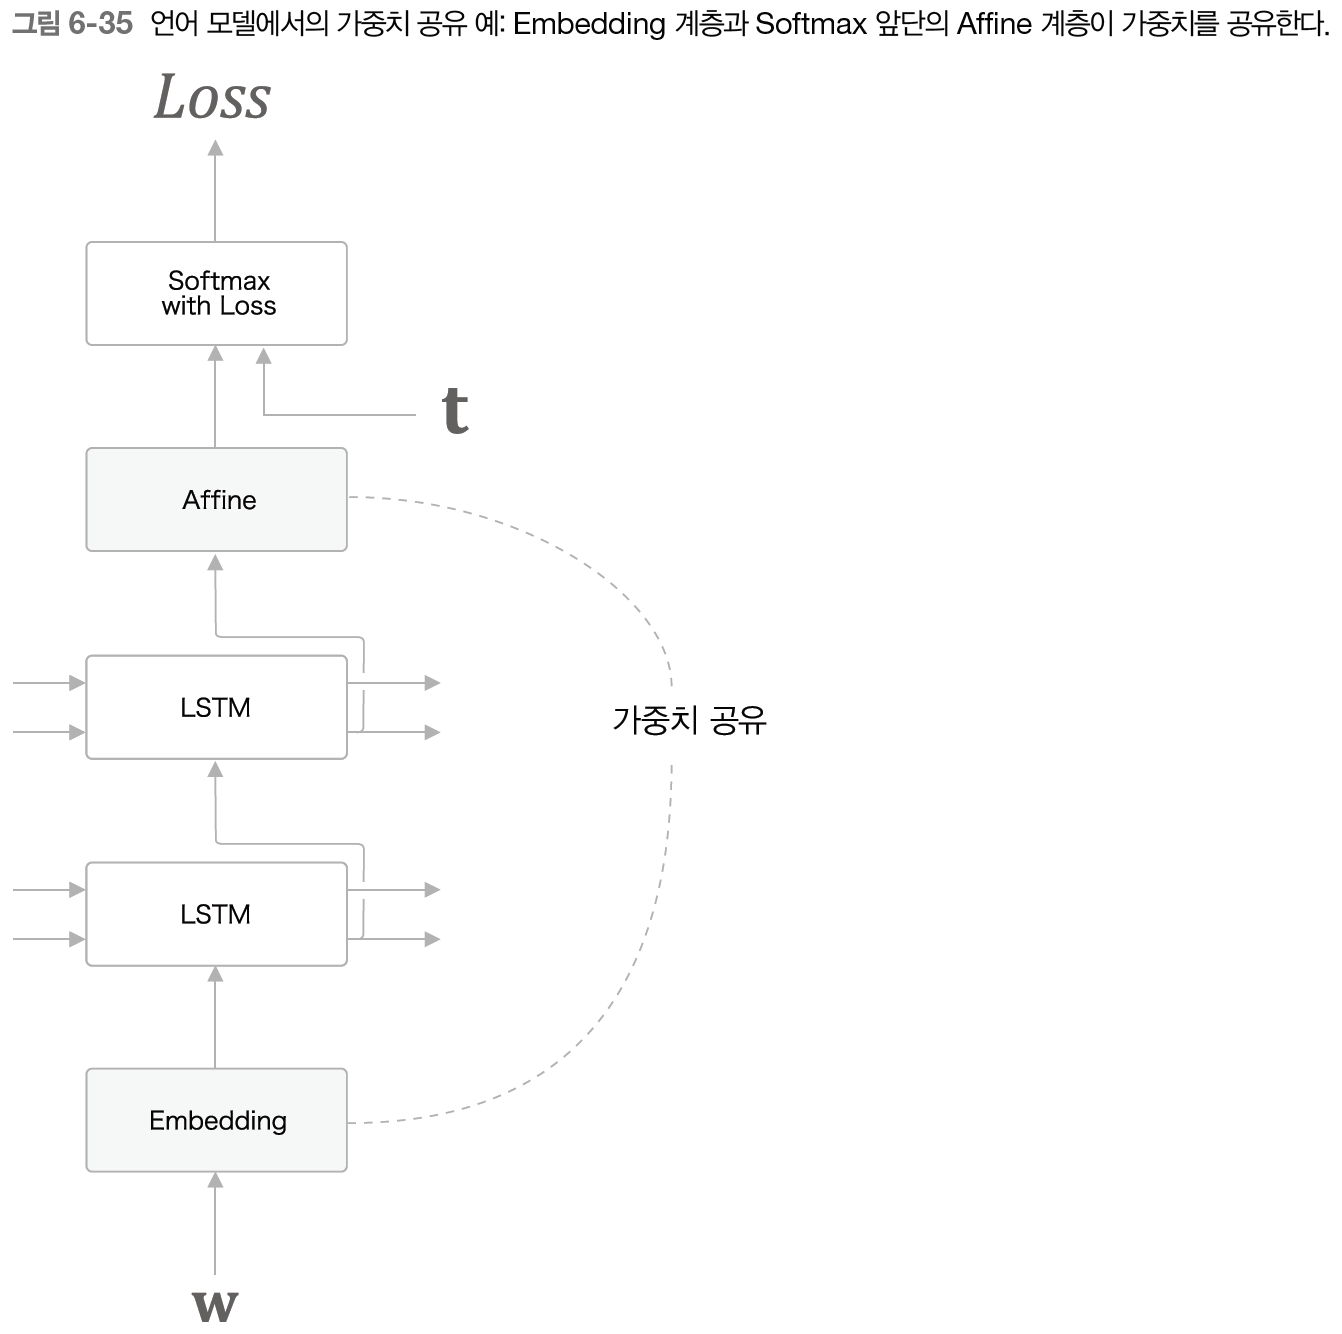

위의 그림처럼 Embedding 계층의 가중치와 Affine 계층의 가중치를 공유하는 방법이 가중치 공유이다. 두 계층이 가중치를 공유함으로써 학습하는 매개변수의 수가 크게 줄고, 정확도도 향상된다. 

어휘 수가 V, LSTM의 은닉 상태의 차원수가 H라면 Embedding 계층의 가중치의 형상은 VxH이고 Affine 계층의 가중치 형상은 HxV이다. 이 때 가중치 공유를 적용하려면 Embedding 계층의 가중치를 전치해 Affine 계층의 가중치로 설정하면 된다. 

>가중치 공유가 효과적인 이유는 가중치를 공유함으로써 학습해야할 매개변수의 수가 줄어들고, 그 결과 학습하기가 쉬워지기 때문이다. 또한 매개변수의 수가 줄어들면 과적합이 억제된다.

### 6.5.4 개선된 RNNLM 구현

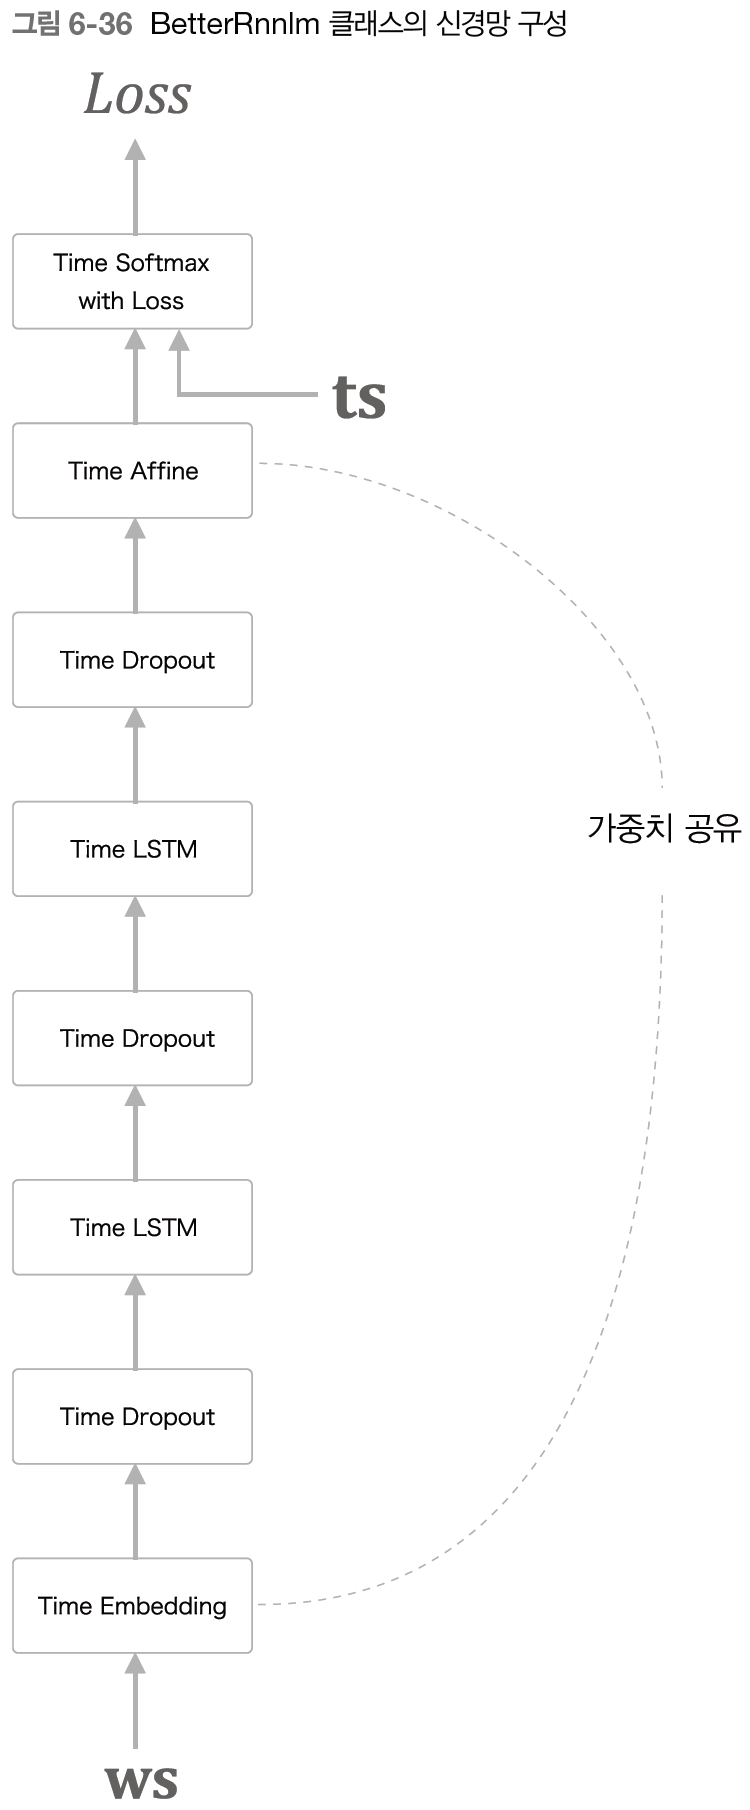

- 개선점은 1) LSTM 계층의 다층화(2층), 2) 드롭아웃 사용(깊이 방향), 3) 가중치 공유(Embedding 계층과 Affine 계층에서 가중치 공유)

In [13]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세 가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

매 에폭에서 검증 데이터로 퍼플렉서티를 평가하고 그 값이 나빠졌을 경우에만 학습룰을 낮춘다. 이 기술은 실전에서 자주 쓰이고, 더 좋은 결과가 나온다.

In [19]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
# from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

# if config.GPU:
#     corpus = to_gpu(corpus)
#     corpus_val = to_gpu(corpus_val)
#     corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0     # 검증데이터로 퍼플렉서티를 평가하고 그 값이 기존의 값보다 낮으면 학습률 낮추기
        optimizer.lr = lr 

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9999.40
| 에폭 1 |  반복 21 / 1327 | 시간 19[s] | 퍼플렉서티 4015.61
| 에폭 1 |  반복 41 / 1327 | 시간 37[s] | 퍼플렉서티 1907.92
| 에폭 1 |  반복 61 / 1327 | 시간 55[s] | 퍼플렉서티 1364.33
| 에폭 1 |  반복 81 / 1327 | 시간 73[s] | 퍼플렉서티 1100.13
| 에폭 1 |  반복 101 / 1327 | 시간 91[s] | 퍼플렉서티 869.93
| 에폭 1 |  반복 121 / 1327 | 시간 109[s] | 퍼플렉서티 794.68
| 에폭 1 |  반복 141 / 1327 | 시간 127[s] | 퍼플렉서티 729.00
| 에폭 1 |  반복 161 / 1327 | 시간 144[s] | 퍼플렉서티 677.62
| 에폭 1 |  반복 181 / 1327 | 시간 163[s] | 퍼플렉서티 688.39
| 에폭 1 |  반복 201 / 1327 | 시간 181[s] | 퍼플렉서티 578.57
| 에폭 1 |  반복 221 / 1327 | 시간 199[s] | 퍼플렉서티 571.06
| 에폭 1 |  반복 241 / 1327 | 시간 217[s] | 퍼플렉서티 523.36
| 에폭 1 |  반복 261 / 1327 | 시간 235[s] | 퍼플렉서티 550.64
| 에폭 1 |  반복 281 / 1327 | 시간 253[s] | 퍼플렉서티 516.90
| 에폭 1 |  반복 301 / 1327 | 시간 271[s] | 퍼플렉서티 446.00
| 에폭 1 |  반복 321 / 1327 | 시간 289[s] | 퍼플렉서티 402.27
| 에폭 1 |  반복 341 / 1327 | 시간 307[s] | 퍼플렉서티 456.22
| 에폭 1 |  반복 361 / 1327 | 시간 325[s] | 퍼플렉서티 460.00
| 에폭 1 |  반복 381 / 1327 | 시간 343[s] | 퍼

KeyboardInterrupt: 

시간이 너무 오래 걸려서 중간에 중단함.

이 모델의 학습은 CPU에서는 2일, GPU에서는 5시간 정도 걸릴 수 있다. 따라서 학습을 마친 가중치를 다음 URL에 준비했다.

http://www.oreilly.co.jp/pub/9784873118369/BetterRnnlm.pkl

이 코드를 실행하면 퍼플렉서티가 순조롭게 낮아지며 테스트 데이터로 얻은 최종 퍼플렉서티는 75.76 정도가 될 것이다. 

### 6.5.5 첨단 연구로

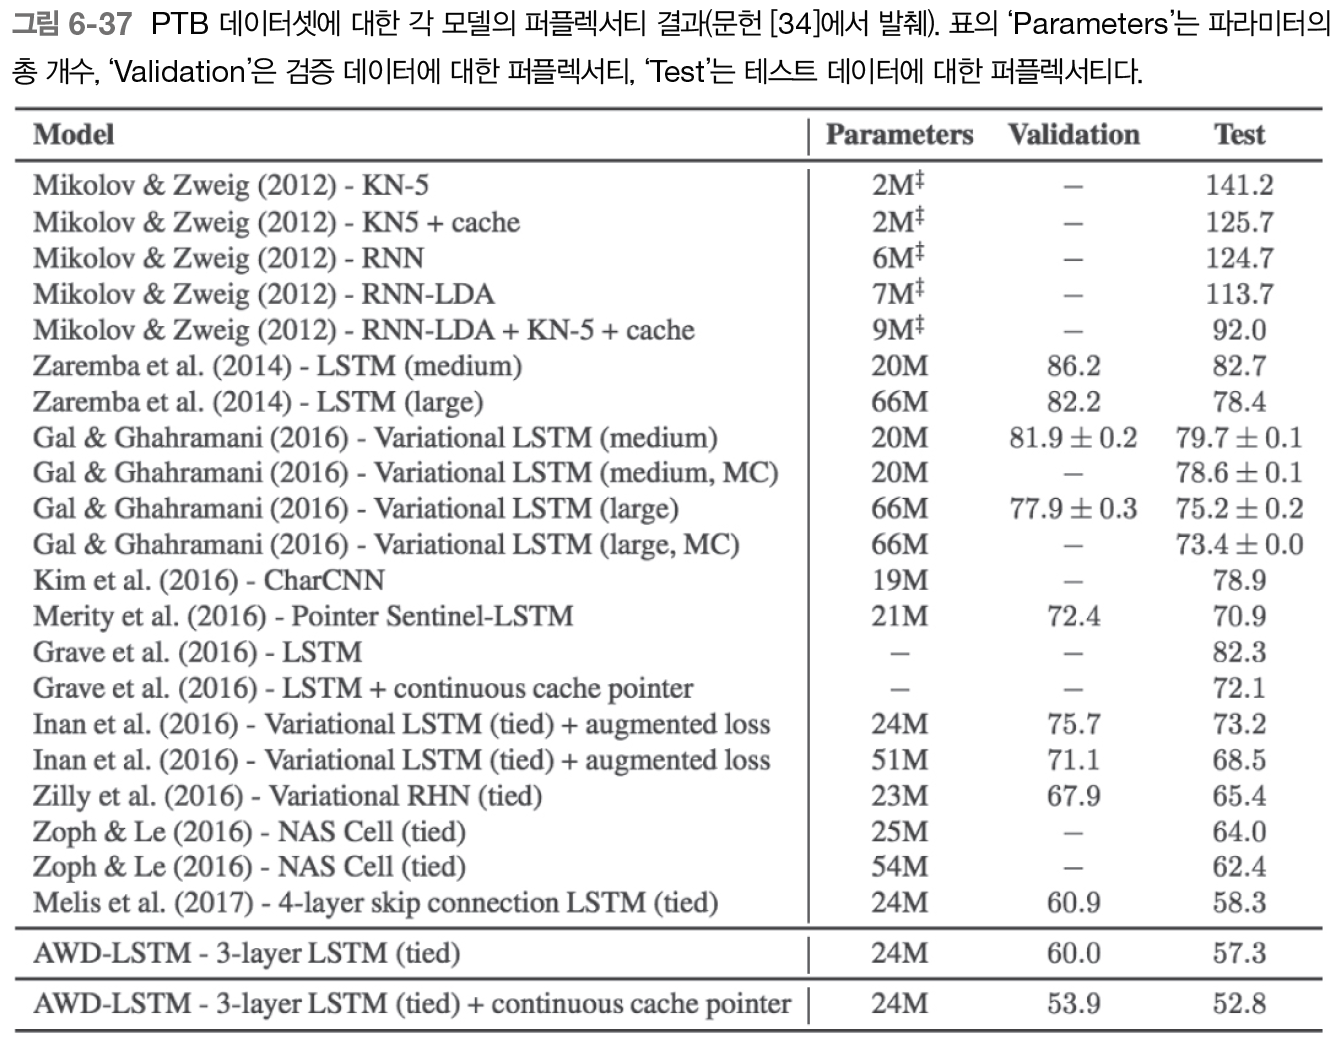

첨단 모델에서도 다층 LSTM을 사용하고, 드롭아웃 기반의 정규화(변형 드롭아웃과 DropConnect)를 수행하며, 가중치 공유도 수행한다. 더 세련된 최적화와 정규화 기법이 적용되고 하이퍼파라미터 튜닝도 매우 정밀하게 하고 있다. 

>DropConnect: 가중치 자체를 무작위로 무시하는 기법